In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

# 1. Import and process the data
df = pd.read_csv('temperature_data_processed.csv')
df['date'] = pd.to_datetime(df["date"], format="%Y%m%d")
df = df[df['temp'] != -999]  # Remove missing data

# Parse date to add explicit columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
print(f"Number of unique stations: {df['stationid'].nunique()}")

Dataset shape after cleaning: (6956669, 7)
Years covered: 1781 - 2024
Number of unique stations: 80


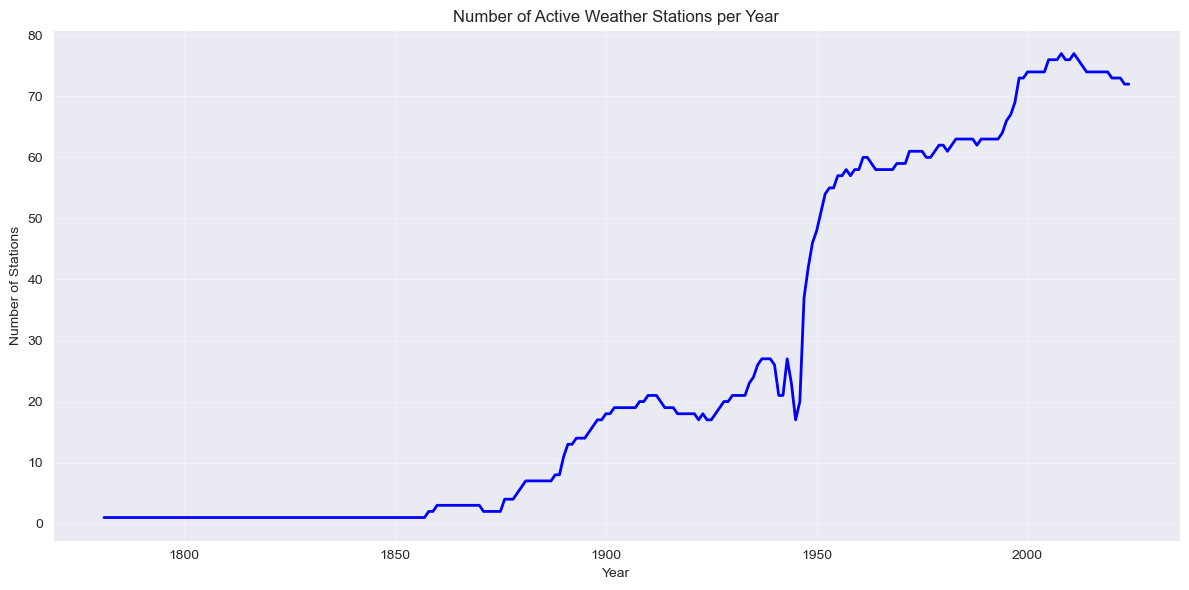

Peak number of stations: 77 in 2008
Minimum number of stations: 1 in 1781


In [2]:
# 2. Examine how many stations contributed measurements in each year
stations_per_year = df.groupby('year')['stationid'].nunique().reset_index()
stations_per_year.columns = ['year', 'num_stations']

plt.figure(figsize=(12, 6))
plt.plot(stations_per_year['year'], stations_per_year['num_stations'], 'b-', linewidth=2)
plt.title('Number of Active Weather Stations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some statistics
print(f"Peak number of stations: {stations_per_year['num_stations'].max()} in {stations_per_year.loc[stations_per_year['num_stations'].idxmax(), 'year']}")
print(f"Minimum number of stations: {stations_per_year['num_stations'].min()} in {stations_per_year.loc[stations_per_year['num_stations'].idxmin(), 'year']}")

In [3]:
# 3. Identify reference stations (active in both 1960 and 2020)
stations_1960 = set(df[df['year'] == 1960]['stationid'].unique())
stations_2020 = set(df[df['year'] == 2020]['stationid'].unique())
reference_stations = list(stations_1960.intersection(stations_2020))

print(f"Stations active in 1960: {len(stations_1960)}")
print(f"Stations active in 2020: {len(stations_2020)}")
print(f"Reference stations (active in both): {len(reference_stations)}")
print(f"Reference station IDs: {sorted(reference_stations)}")

Stations active in 1960: 58
Stations active in 2020: 73
Reference stations (active in both): 53
Reference station IDs: [np.int64(164), np.int64(183), np.int64(232), np.int64(282), np.int64(403), np.int64(433), np.int64(691), np.int64(722), np.int64(880), np.int64(891), np.int64(1048), np.int64(1270), np.int64(1346), np.int64(1358), np.int64(1420), np.int64(1468), np.int64(1612), np.int64(1639), np.int64(1684), np.int64(1975), np.int64(2014), np.int64(2115), np.int64(2261), np.int64(2290), np.int64(2483), np.int64(2559), np.int64(2667), np.int64(2812), np.int64(3015), np.int64(3032), np.int64(3126), np.int64(3196), np.int64(3631), np.int64(3668), np.int64(3730), np.int64(3761), np.int64(3987), np.int64(4104), np.int64(4177), np.int64(4271), np.int64(4336), np.int64(4466), np.int64(4625), np.int64(4887), np.int64(4911), np.int64(4931), np.int64(5100), np.int64(5371), np.int64(5397), np.int64(5516), np.int64(5705), np.int64(5792), np.int64(5906)]


In [4]:
# 4. Filter the data according to requirements
filtered_data = df[
    (df['stationid'].isin(reference_stations)) &
    (df['year'] >= 1960) & (df['year'] <= 2020) &
    (df['time'].isin([12, 14]))
].copy()  # Use .copy() to avoid the SettingWithCopyWarning

print(f"Filtered dataset shape: {filtered_data.shape}")
print(f"Years in filtered data: {filtered_data['year'].min()} - {filtered_data['year'].max()}")
print(f"Times in filtered data: {sorted(filtered_data['time'].unique())}")

Filtered dataset shape: (1160070, 7)
Years in filtered data: 1960 - 2020
Times in filtered data: [np.int64(12), np.int64(14)]


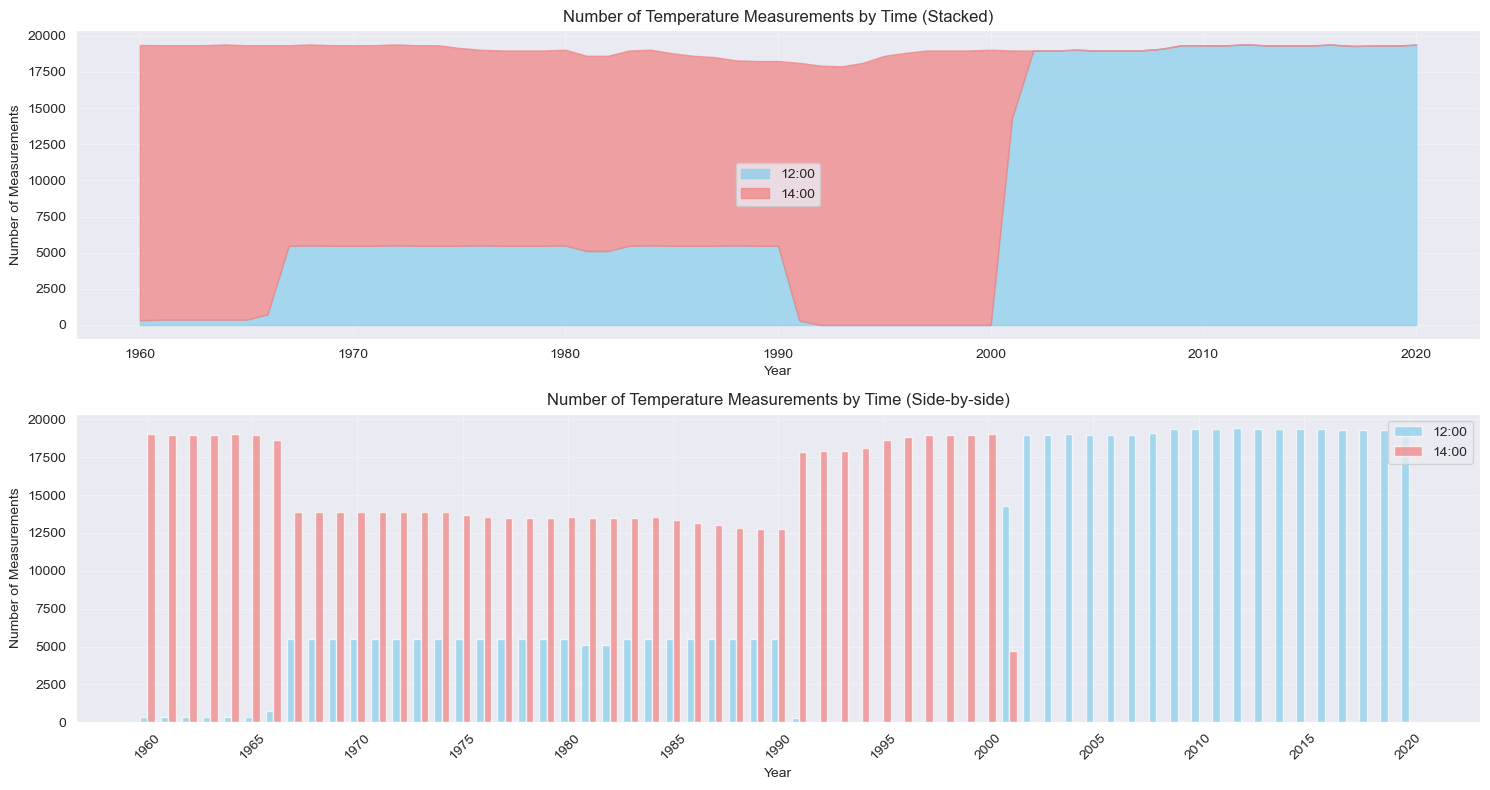

In [5]:
# 5. Show measurements available at times 12 and 14 for each year
time_12_counts = filtered_data[filtered_data['time'] == 12].groupby('year').size()
time_14_counts = filtered_data[filtered_data['time'] == 14].groupby('year').size()

# Create a complete year range and fill missing values with 0
years_range = range(1960, 2021)
time_12_complete = time_12_counts.reindex(years_range, fill_value=0)
time_14_complete = time_14_counts.reindex(years_range, fill_value=0)

plt.figure(figsize=(15, 8))

# Stacked area plot
plt.subplot(2, 1, 1)
plt.fill_between(years_range, 0, time_12_complete, alpha=0.7, label='12:00', color='skyblue')
plt.fill_between(years_range, time_12_complete, time_12_complete + time_14_complete,
                alpha=0.7, label='14:00', color='lightcoral')
plt.title('Number of Temperature Measurements by Time (Stacked)')
plt.xlabel('Year')
plt.ylabel('Number of Measurements')
plt.legend()
plt.grid(True, alpha=0.3)

# Side-by-side comparison
plt.subplot(2, 1, 2)
width = 0.35
x_pos = np.arange(len(years_range))
plt.bar(x_pos - width/2, time_12_complete, width, label='12:00', alpha=0.7, color='skyblue')
plt.bar(x_pos + width/2, time_14_complete, width, label='14:00', alpha=0.7, color='lightcoral')
plt.title('Number of Temperature Measurements by Time (Side-by-side)')
plt.xlabel('Year')
plt.ylabel('Number of Measurements')
plt.xticks(x_pos[::5], years_range[::5], rotation=45)  # Show every 5th year
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

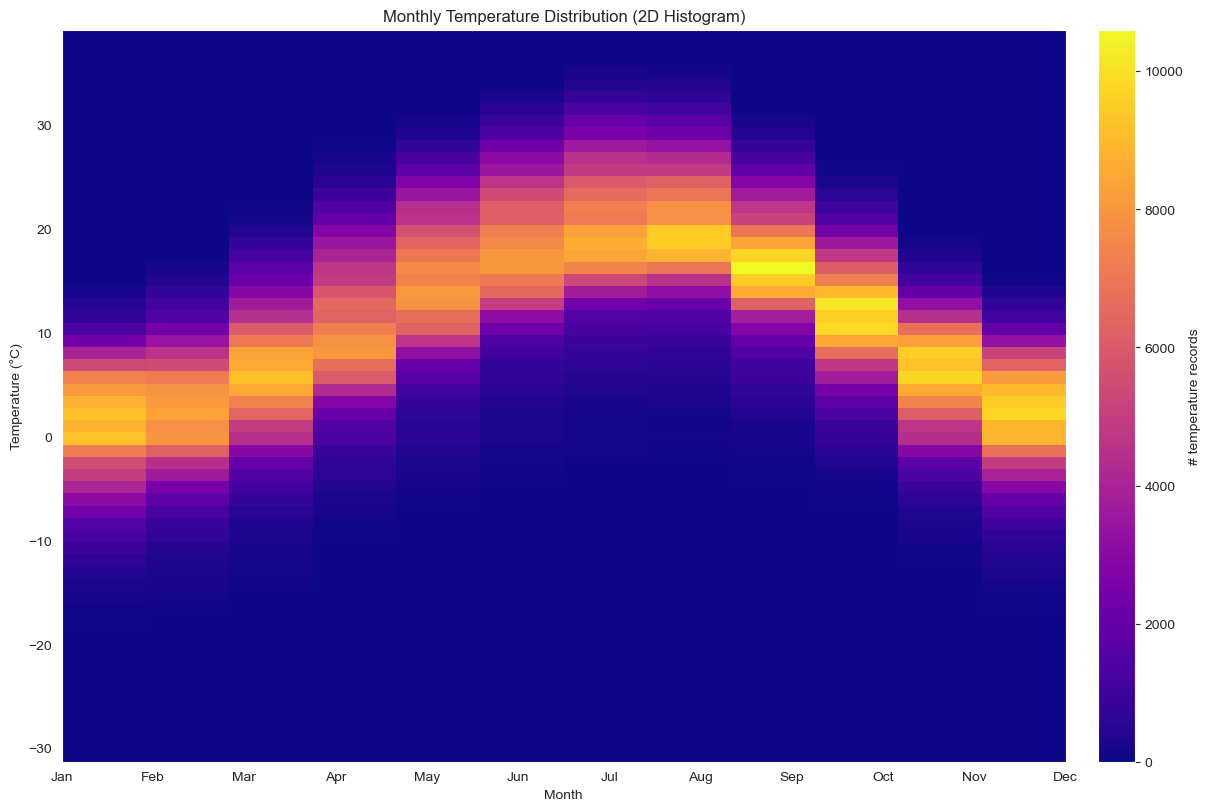

In [10]:
# Exercise 6 - Method 1: 2D Histogram

months = filtered_data['month'].values
temps = filtered_data['temp'].values

fig, axes = plt.subplots(nrows=1, figsize=(12, 8), layout='constrained')

cmap = plt.colormaps["plasma"]
cmap = cmap.with_extremes(bad=cmap(0))
h, month_edges, temp_edges = np.histogram2d(months, temps, bins=[12, 60])

pcm = axes.pcolormesh(month_edges, temp_edges, h.T, cmap=cmap, rasterized=True)
fig.colorbar(pcm, ax=axes, label="# temperature records", pad=0.02)

axes.set_xlabel('Month')
axes.set_ylabel('Temperature (°C)')
axes.set_title('Monthly Temperature Distribution (2D Histogram)')
axes.set_xticks(range(1, 13))
axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


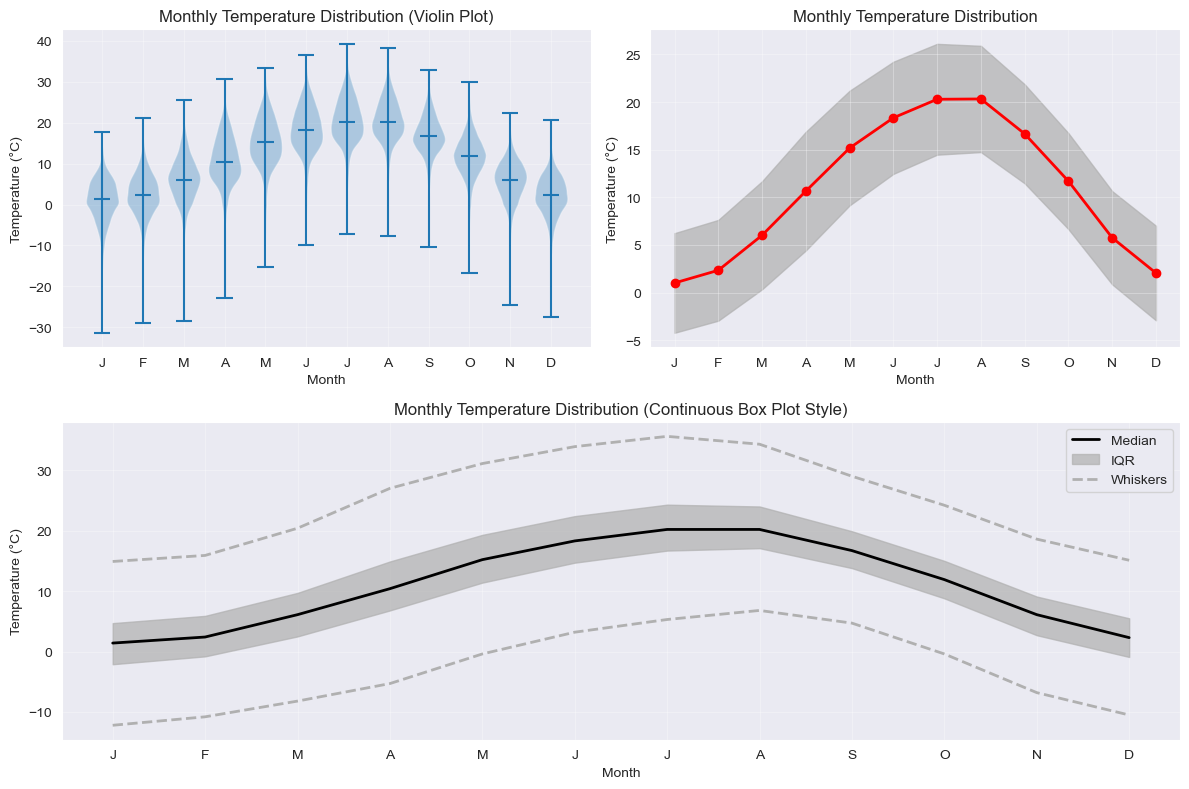

In [7]:
# Exercise 6 - Method 2: Distribution Summaries

def binDataMonths(dataMonth, dataTemp):
    binnedTempLists = [[] for i in range(12)]
    for month, temp in zip(dataMonth, dataTemp):
        binnedTempLists[month-1].append(temp)
    months = np.arange(1, 13)
    return months, binnedTempLists

months = filtered_data['month'].values
temps = filtered_data['temp'].values
monthsX, binnedTempLists = binDataMonths(months, temps)

temp_means = np.array([np.mean(t) for t in binnedTempLists])
temp_std = np.array([np.std(t) for t in binnedTempLists])

fig = plt.figure(figsize=(12, 8))

# Plot 1: Violin plot
fig.add_subplot(2, 2, 1)
parts = plt.violinplot(binnedTempLists, positions=monthsX,
                      widths=0.8, showmedians=True, showextrema=True)

plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperature Distribution (Violin Plot)')
plt.xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.grid(True, alpha=0.3)

# Plot 2: Fill between
fig.add_subplot(2, 2, 2)
plt.fill_between(monthsX, temp_means-temp_std, temp_means+temp_std,
                color="#b0b0b0", zorder=-1, alpha=0.7)
plt.plot(monthsX, temp_means, c="r", marker="o", linewidth=2, markersize=6)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperature Distribution')
plt.xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.grid(True, alpha=0.3)

fig.add_subplot(2, 1, 2)

q = np.array([25, 50, 75])
qDat = np.array([np.percentile(t, q) for t in binnedTempLists])
IQR = qDat[:, 2] - qDat[:, 0]

wlo = qDat[:, 0] - 1.5*IQR
whi = qDat[:, 2] + 1.5*IQR

for i in range(len(binnedTempLists)):
    if len(binnedTempLists[i]) > 0:
        y = np.array(binnedTempLists[i])
        valid_lo = y[y > wlo[i]]
        valid_hi = y[y < whi[i]]
        if len(valid_lo) > 0:
            wlo[i] = np.min(valid_lo)
        if len(valid_hi) > 0:
            whi[i] = np.max(valid_hi)

plt.plot(monthsX, qDat[:, 1], c="k", linewidth=2, label='Median')
plt.fill_between(monthsX, qDat[:, 2], qDat[:, 0], color="#b0b0b0", alpha=0.7, label='IQR')
plt.plot(monthsX, wlo, c="#b0b0b0", ls="dashed", linewidth=2, label='Whiskers')
plt.plot(monthsX, whi, c="#b0b0b0", ls="dashed", linewidth=2)

plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperature Distribution (Continuous Box Plot Style)')
plt.xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

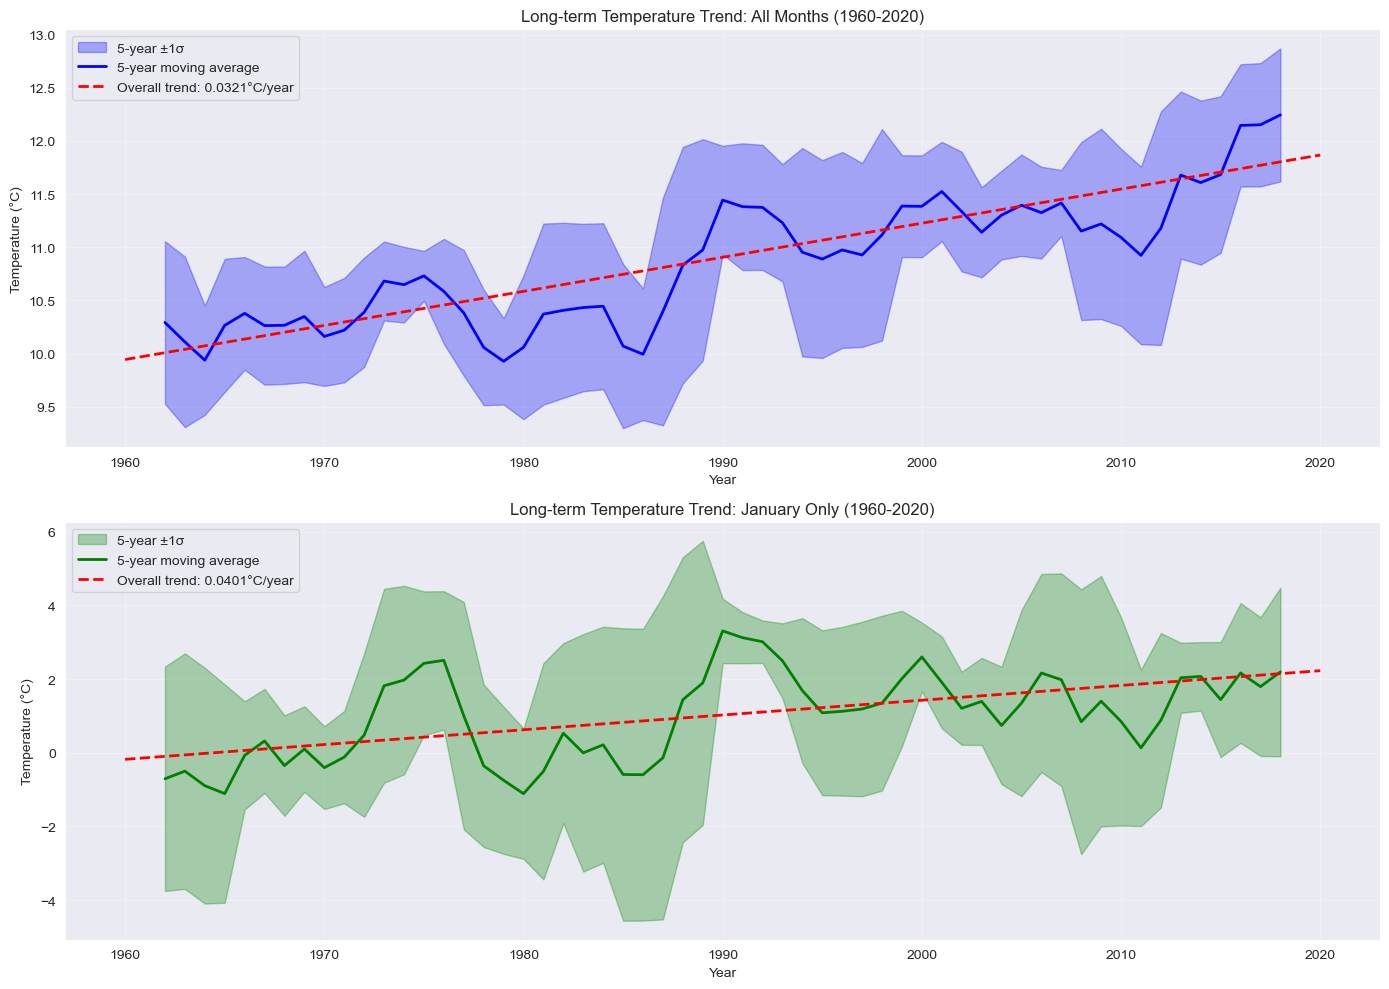

Temperature Trend Analysis (1960-2020):
All months - Overall warming: 1.92°C over 60 years
All months - Rate: 0.0321°C per year
January only - Overall warming: 2.41°C over 60 years
January only - Rate: 0.0401°C per year
Comparison: January warming is 1.25x the overall rate


In [26]:
# Exercise 7 - Long-term Temperature Trends

def binData(dataX, dataY, nBins):
    vMax = np.max(dataX)
    vMin = np.min(dataX)
    binNr = np.clip(((dataX-vMin)/(vMax-vMin+1E-10)*nBins).astype(np.int32), 0, nBins-1)
    midpoints = ((np.arange(nBins)+0.5)/nBins)*(vMax-vMin)+vMin

    binnedYLists = [[] for i in range(nBins)]
    for b, y in zip(binNr, dataY):
        binnedYLists[b].append(y)
    return midpoints, binnedYLists


window_size = 5  # 5-year moving window
yearly_means_all = filtered_data.groupby('year')['temp'].mean()

january_data = filtered_data[filtered_data['month'] == 1]
yearly_means_january = january_data.groupby('year')['temp'].mean()

# Rolling statistics
rolling_mean_all = yearly_means_all.rolling(window=window_size, center=True).mean()
rolling_std_all = yearly_means_all.rolling(window=window_size, center=True).std()
rolling_mean_january = yearly_means_january.rolling(window=window_size, center=True).mean()
rolling_std_january = yearly_means_january.rolling(window=window_size, center=True).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# All months
ax1.fill_between(rolling_mean_all.index,
                rolling_mean_all - rolling_std_all,
                rolling_mean_all + rolling_std_all,
                alpha=0.3, color='blue', label=f'{window_size}-year ±1σ')

ax1.plot(rolling_mean_all.index, rolling_mean_all, 'b-', linewidth=2,
         label=f'{window_size}-year moving average')

z_all = np.polyfit(yearly_means_all.index, yearly_means_all, 1)
p_all = np.poly1d(z_all)
ax1.plot(yearly_means_all.index, p_all(yearly_means_all.index), "r--", linewidth=2,
         label=f'Overall trend: {z_all[0]:.4f}°C/year')

ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Long-term Temperature Trend: All Months (1960-2020)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# January only
ax2.fill_between(rolling_mean_january.index,
                rolling_mean_january - rolling_std_january,
                rolling_mean_january + rolling_std_january,
                alpha=0.3, color='green', label=f'{window_size}-year ±1σ')

ax2.plot(rolling_mean_january.index, rolling_mean_january, 'g-', linewidth=2,
         label=f'{window_size}-year moving average')

z_january_annual = np.polyfit(yearly_means_january.index, yearly_means_january, 1)
p_january_annual = np.poly1d(z_january_annual)
ax2.plot(yearly_means_january.index, p_january_annual(yearly_means_january.index), "r--", linewidth=2,
         label=f'Overall trend: {z_january_annual[0]:.4f}°C/year')

ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Long-term Temperature Trend: January Only (1960-2020)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis
print("Temperature Trend Analysis (1960-2020):")
print(f"All months - Overall warming: {z_all[0] * 60:.2f}°C over 60 years")
print(f"All months - Rate: {z_all[0]:.4f}°C per year")
print(f"January only - Overall warming: {z_january_annual[0] * 60:.2f}°C over 60 years")
print(f"January only - Rate: {z_january_annual[0]:.4f}°C per year")
print(f"Comparison: January warming is {z_january_annual[0]/z_all[0]:.2f}x the overall rate")